# Machine Learning: Intro to Scikit-Learn

**Advanced Astroinformatics Student Project**

*N. Hernitschek, 2022*



---
## Contents
* [Recap, Questions](#first-bullet)
* [Plotting](#second-bullet)
* [Supervised Classification - Binary Classifiers](#third-bullet)
* [Supervised Classification - Multiclass Classifiers](#fourth-bullet)
* [Summary](#fifth-bullet)


## 1. Recap, Questions <a class="anchor" id="first-bullet"></a>

Time for questions!

Your **tasks until this week** were:

Using the TESS features you have calculated, try to code k-means clustering in the same way as shown here for the `iris` data set.

Carry out 10-fold verification, and make a confusion matrix.

Try to interpret your results.
How do your results differ from the a) _TESS_lightcurves_outliercleaned, b)  _TESS_lightcurves_median_after_detrended, c) _TESS_lightcurves_raw?

## 2. Plotting <a class="anchor" id="second-bullet"></a>

We need plots that tell us the most about what is happening.


Plots should be **informative**. For this task, which kinds of plots could you think of?


We now have:
* triangle plot showing the feature space (parameter space) for each kind of light curves (outliercleaned, detrended, raw)
* confusion matrix showing the classifier performance.

It would be interesting to see how different clusters cover different parts of the feature space. I.e.:
A plot like this:

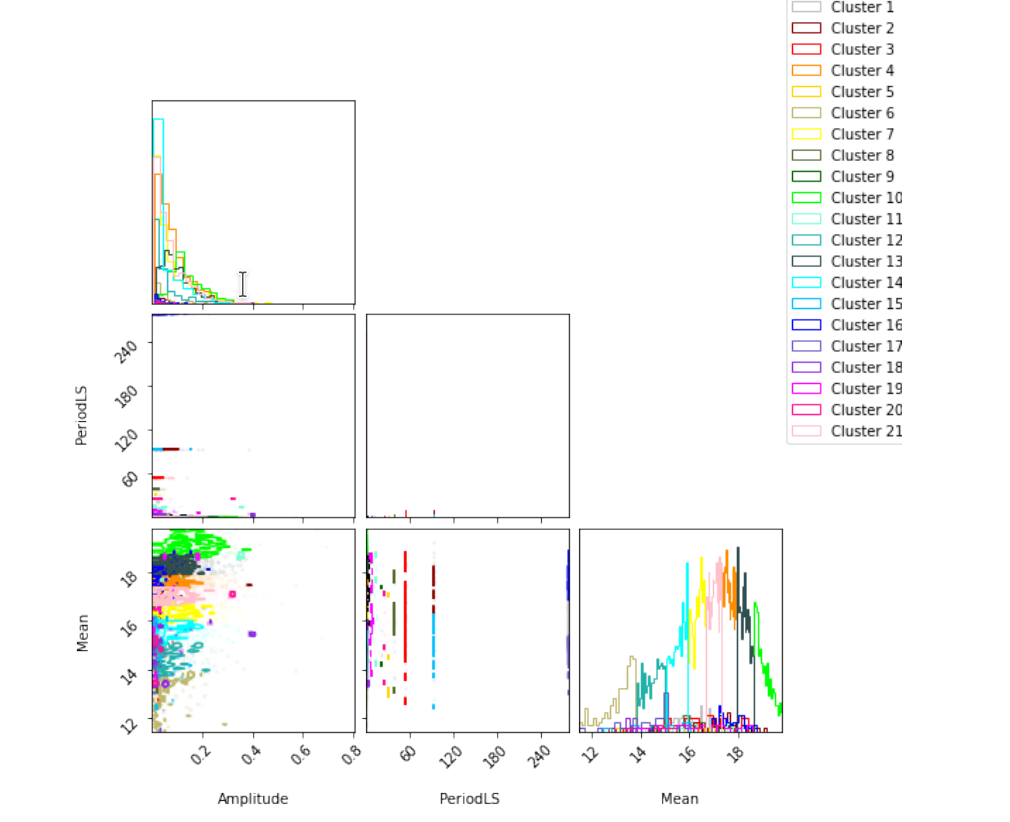

**Before** you start to code: What would be your approach?

For **testing** your code, I recommend as always: try it on a smaller data set, i.e. here to first plot just a few clusters instead of all.

## 3. Supervised Classification - Binary Classifiers <a class="anchor" id="third-bullet"></a>

Random forest classifiers generate decision trees from bootstrap samples. A interesting aspect of random forests is that the features on which to generate the tree are selected at random from the full set of features in the data (the number of features selected per split level is typically the square root of the total number of attributes). The final classification from the random forest is based on the averaging of the classifications of each of the individual decision trees. So, you can literally give it anything (including attributes that you might not otherwise think would be useful for classification).

Random forests help to overcome some of the limitations of decision trees.

As before, cross-validation can be used to determine the optimal depth. Generally the number of trees that are chosen is the number at which the cross-validation error plateaus.

As there are a variety of supervised classification algorithms, in the following we apply a few to a test data set in order to distinguish quasars from stars in a binary classification problem.

GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier


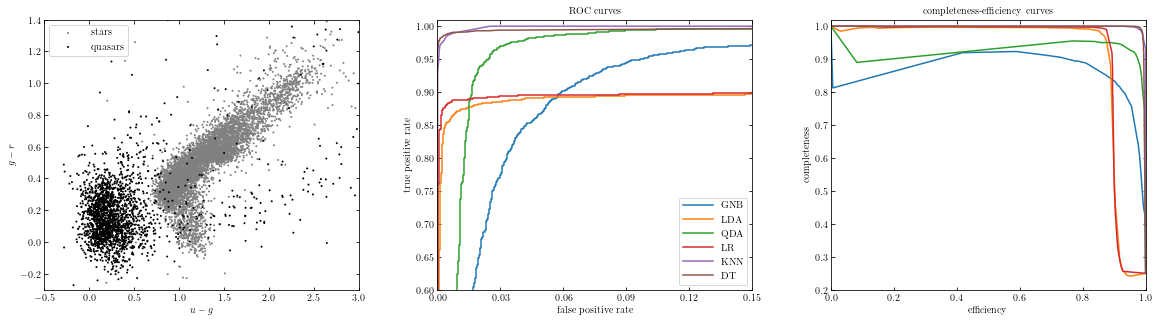

In [1]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general

from __future__ import print_function

import numpy as np
from matplotlib import pyplot as plt

from astroML.utils import split_samples
from astroML.utils import completeness_contamination


from sklearn.metrics import roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,
                                           QuadraticDiscriminantAnalysis)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from astroML.classification import GMMBayes


#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

#------------------------------------------------------------
# Fetch data and split into training and test samples
from astroML.datasets import fetch_dr7_quasar
from astroML.datasets import fetch_sdss_sspp

quasars = fetch_dr7_quasar()
stars = fetch_sdss_sspp()

# Truncate data for speed
quasars = quasars[::5]
stars = stars[::5]

# stack colors into matrix X
Nqso = len(quasars)
Nstars = len(stars)
X = np.empty((Nqso + Nstars, 4), dtype=float)

X[:Nqso, 0] = quasars['mag_u'] - quasars['mag_g']
X[:Nqso, 1] = quasars['mag_g'] - quasars['mag_r']
X[:Nqso, 2] = quasars['mag_r'] - quasars['mag_i']
X[:Nqso, 3] = quasars['mag_i'] - quasars['mag_z']

X[Nqso:, 0] = stars['upsf'] - stars['gpsf']
X[Nqso:, 1] = stars['gpsf'] - stars['rpsf']
X[Nqso:, 2] = stars['rpsf'] - stars['ipsf']
X[Nqso:, 3] = stars['ipsf'] - stars['zpsf']

y = np.zeros(Nqso + Nstars, dtype=int)
y[:Nqso] = 1

# split into training and test sets
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.9, 0.1],
                                                     random_state=0)


#------------------------------------------------------------
# Compute fits for all the classifiers
def compute_results(*args):
    names = []
    probs = []

    for classifier, kwargs in args:
        print(classifier.__name__)
        model = classifier(**kwargs)
        model.fit(X, y)
        y_prob = model.predict_proba(X_test)

        names.append(classifier.__name__)
        probs.append(y_prob[:, 1])

    return names, probs

LRclass_weight = dict([(i, np.sum(y_train == i)) for i in (0, 1)])

names, probs = compute_results((GaussianNB, {}),
                               (LinearDiscriminantAnalysis, {}),
                               (QuadraticDiscriminantAnalysis, {}),
                               (LogisticRegression,
                                dict(class_weight=LRclass_weight)),
                               (KNeighborsClassifier,
                                dict(n_neighbors=10)),
                               (DecisionTreeClassifier,
                                dict(random_state=0, max_depth=12,
                                     criterion='entropy')))

#------------------------------------------------------------
# Plot results
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(left=0.1, right=0.95, bottom=0.15, top=0.9, wspace=0.25)

# First axis shows the data
ax1 = fig.add_subplot(131)
#im = ax1.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=4,
#                 linewidths=0, edgecolors='none',
#                 cmap=plt.cm.binary)
#ax1.legend ('quasars', 'stars')


ax1.scatter(X_test[:, 0][y_test==0], X_test[:, 1][y_test==0], c='grey', s=4,
                 linewidths=0, edgecolors='none', label='stars')
ax1.scatter(X_test[:, 0][y_test==1], X_test[:, 1][y_test==1], c='k', s=4,
                 linewidths=0, edgecolors='none',label='quasars')

ax1.legend()




ax1.set_xlim(-0.5, 3.0)
ax1.set_ylim(-0.3, 1.4)
ax1.set_xlabel('$u - g$')
ax1.set_ylabel('$g - r$')

labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              LogisticRegression='LR')

# Second axis shows the ROC curves
ax2 = fig.add_subplot(132)
for name, y_prob in zip(names, probs):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    ax2.plot(fpr, tpr, label=labels[name])
    
    ######
    
# Third axis shows the completeness-efficiency curves

ax3 = fig.add_subplot(133)
for name, y_prob in zip(names, probs):
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred, y_test)
    ax3.plot(comp,1 - cont, label=labels[name])
    

ax2.legend(loc=4)
ax2.set_title('ROC curves')
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_xlim(0, 0.15)
ax2.set_ylim(0.6, 1.01)
ax2.xaxis.set_major_locator(plt.MaxNLocator(5))


ax3.set_title('completeness-efficiency curves')
ax3.set_xlabel('efficiency')
ax3.set_ylabel('completeness')
ax3.set_xlim(0, 1.0)
ax3.set_ylim(0.2, 1.02)


plt.show()

You see two **diagnostic plots** (see also lecture slides 5).

A receiver operating characteristic curve, or **ROC curve**, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. 


One concern about ROC curves is that they are sensitive to the relative
sample sizes: if there are many more background events than source
events, small false positive results can dominate a signal.
For these cases we can plot completeness versus efficiency.



Here we see that to get higher completeness, you could actually suffer significantly in terms of efficiency, but your false positive rate (FPR) might not go up that much if there are lots of true negatives.
Note that the desired completeness and efficiency is chosen by selecting a decision boundary. The curves show what these possible choices are. Generally, one wants to chose a decision boundary that **maximizes the area
under the** ROC (or completeness versus efficiency) **curve**.


remember: we defined



\begin{equation*}
{\rm completeness} = \frac{\rm true\ positives}{\rm true\ positives + false\ negatives}
\end{equation*}

\begin{equation*} 
{\rm contamination} = \frac{\rm false\ positives}{\rm true\ positives + false\ positives} = {\rm false\ discovery\ rate}
\end{equation*}

Instead of contamination, often also efficiency (also called purity) is used: ${\rm efficiency} = \rm{(1 - contamination)}$




## 3. Supervised Classification - Multiclass Classifiers <a class="anchor" id="third-bullet"></a>


In many cases we not only want to discriminate between two classes, but many. This is called a **multiclass classifier**. That's exactly what we need for the TESS data.
In the following, you will see a complete example using the `iris` test dataset.

In [2]:

#Importing Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.datasets import load_iris


In [3]:
#create the data set from the original iris data set to look more like a typical astronomical data set
iris = load_iris(as_frame=True)

data = iris.data
target = iris.target

#replace target with names like usually found in astronomical data sets
target_names = target.replace([0, 1, 2], ['setosa', 'versicolor', 'virginica'])

dataset = pd.concat([data,target_names.reindex(data.index)], axis=1)


#Renaming the columns
dataset.columns = ['sepal length in cm', 'sepal width in cm','petal length in cm','petal width in cm','species']
print('Shape of the dataset: ' + str(data.shape))


print(dataset)



# we now have our data set, like we have read it from a cvs text file


Shape of the dataset: (150, 4)
     sepal length in cm  sepal width in cm  petal length in cm  \
0                   5.1                3.5                 1.4   
1                   4.9                3.0                 1.4   
2                   4.7                3.2                 1.3   
3                   4.6                3.1                 1.5   
4                   5.0                3.6                 1.4   
..                  ...                ...                 ...   
145                 6.7                3.0                 5.2   
146                 6.3                2.5                 5.0   
147                 6.5                3.0                 5.2   
148                 6.2                3.4                 5.4   
149                 5.9                3.0                 5.1   

     petal width in cm    species  
0                  0.2     setosa  
1                  0.2     setosa  
2                  0.2     setosa  
3                  0.2     setos

**Creating the dependent variable class**

We are converting species column values from ['Iris-setosa','Iris-versicolor','Iris-virginica'] to [0,1,2]. This is an essential step as the scikit-learn's Random Forest can't predict text — it can only predict numbers.

Yes, we had just converted it from numbers to text labels... This was done to mimic we were reading in a typical text file.

In addition, we need to store the factor conversions to remember what number is substituting the text.
The code below will perform the following:

 *   Use `pandas` factorize function to factorize the species column in the dataset. This will create both factors and the definitions for the factors.
 *   Store the factorized column as species.
 *   Store the definitions for the factors.
 *   Show the first five rows for the species column and the defintions array.


In [4]:
#Creating the dependent variable class
factor = pd.factorize(dataset['species'])
dataset.species = factor[0]
definitions = factor[1]
print(dataset.species.head())
print(definitions)

0    0
1    0
2    0
3    0
4    0
Name: species, dtype: int64
Index(['setosa', 'versicolor', 'virginica'], dtype='object')


**Extracting Features and Output**

We need to split the dataset into **independent** and **dependent variables**. In our dataset, the first four columns are independent variables, whereas the last column, 'species', is the dependent variable.



In [5]:
#Splitting the data into independent and dependent variables
X = dataset.iloc[:,0:4].values
y = dataset.iloc[:,4].values
print('The independent features set: ')
print(X[:5,:])
print('The dependent variable: ')
print(y[:5])

The independent features set: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
The dependent variable: 
[0 0 0 0 0]


**Train-Test Data Splitting**

We will use 75% of the data for training and the remaining 25% as test data (i.e., 75% of 150 rows as 112 rows for training and 38 rows for testing). 

Also, the reason for such high number of test case percentages is due to fewer numbers of rows for the model. Generally, 80/20 rule for train-test is used when data is sufficiently high.

The below code uses the prebuilt function 'train_test_split' in a sklearn library for creating the train and test arrays for both independent and dependent variable. Also, random_state = 21 is assigned for random distribution of data.

In [6]:
# Creating the Training and Test set from data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)


**Feature Scaling**

This is a very important step in machine learning. It helps the algorithm quickly learn a better solution to the problem.

We will use a standard scaler provided in the sklearn library. It subtracts the mean value of the observation and then divides it by the unit variance of the observation.
We will perform the following steps:

    Define a scaler by calling the function from sklearn library.
    Transform train feature dataset (X_train) and fit the scaler on train feature dataset.
    Use the scaler to transform test feature dataset (X_test).


In [7]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**Training the model**

We define the parameters for the random forest training as follows:

    n_estimators: This is the number of trees in the random forest classification. We have defined 10 trees in our random forest.
    criterion: This is the loss function used to measure the quality of the split. There are two available options in sklearn — gini and entropy. We have used entropy.
    random_state: This is the seed used by the random state generator for randomizing the dataset.

Next, we use the training dataset (both dependent and independent to train the random forest)

In [8]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=42)

**Evaluating the performance**

Performance evaluation of the trained model consists of following steps:

    Predicting the species class of the test data using test feature set (X_test). We will use the predict function of the random forest classifier to predict classes.
    Converting the numeric classes of the predicted values and the test actual values into textual equivalent. This involves the following steps:
        Creating dictionary for mapping tables from class to text — we use dict function along with zip to create the required dictionary.
        Transforming the test-actual and test-predict database from numeric classes to textual classes.
        Evaluating the performance of the classifier using Confusion Matrix.


In [9]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
#Reverse factorize (converting y_pred from 0s,1s and 2s to Iris-setosa, Iris-versicolor and Iris-virginica
reversefactor = dict(zip(range(3),definitions))
y_test = np.vectorize(reversefactor.get)(y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Species'], colnames=['Predicted Species']))


Predicted Species  setosa  versicolor  virginica
Actual Species                                  
setosa                 13           0          0
versicolor              0          12          3
virginica               0           0         10


**Feature Importance**

In [10]:
print(list(zip(dataset.columns[0:4], classifier.feature_importances_)))


[('sepal length in cm', 0.13838770253303928), ('sepal width in cm', 0.006840004111259038), ('petal length in cm', 0.43430955033126234), ('petal width in cm', 0.4204627430244394)]


## 3.1 10-fold verification <a class="anchor" id="third-bullet"></a>


In the example above we saw how to split the initial data set into a training and testing data set.
Whereas this can be done as a first step, it is highly recommended using **10-fold verification**, where in turn 10 % of the data are held out as a test set and 90 % are used for training.

In the following, we will implement this in the same way as the example above, using the `iris`data set.

Shape of the dataset: (150, 4)
     sepal length in cm  sepal width in cm  petal length in cm  \
0                   5.1                3.5                 1.4   
1                   4.9                3.0                 1.4   
2                   4.7                3.2                 1.3   
3                   4.6                3.1                 1.5   
4                   5.0                3.6                 1.4   
..                  ...                ...                 ...   
145                 6.7                3.0                 5.2   
146                 6.3                2.5                 5.0   
147                 6.5                3.0                 5.2   
148                 6.2                3.4                 5.4   
149                 5.9                3.0                 5.1   

     petal width in cm    species  
0                  0.2     setosa  
1                  0.2     setosa  
2                  0.2     setosa  
3                  0.2     setos

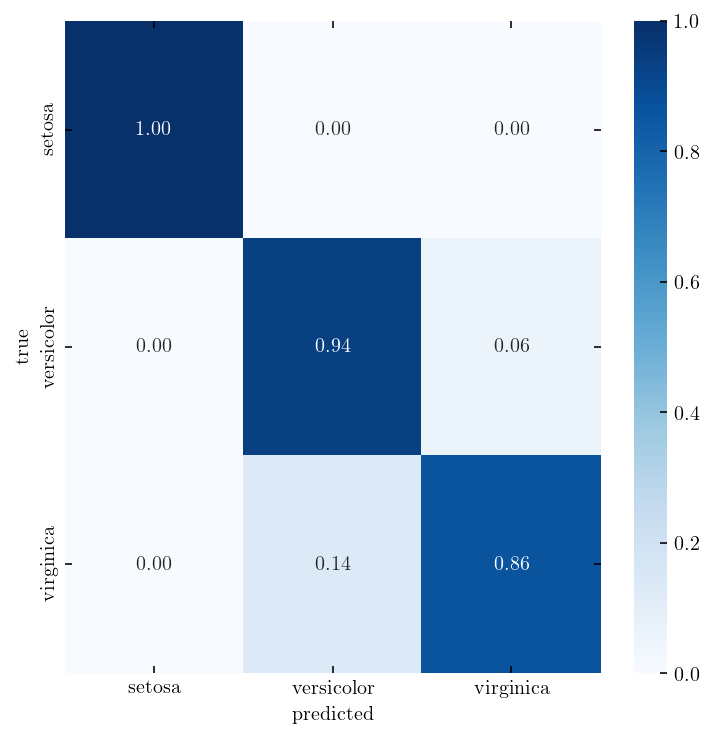

In [12]:

#Importing Libraries

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from sklearn.datasets import load_iris


from sklearn.model_selection import KFold




from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#create the data set from the original iris data set to look more like a typical astronomical data set
iris = load_iris(as_frame=True)

data = iris.data
target = iris.target

#replace target with names like usually found in astronomical data sets
target_names = target.replace([0, 1, 2], ['setosa', 'versicolor', 'virginica'])

dataset = pd.concat([data,target_names.reindex(data.index)], axis=1)


#Renaming the columns
dataset.columns = ['sepal length in cm', 'sepal width in cm','petal length in cm','petal width in cm','species']
print('Shape of the dataset: ' + str(data.shape))


# we now have our data set, like we have read it from a cvs text file
print(dataset)



#Creating the dependent variable class
factor = pd.factorize(dataset['species'])
dataset.species = factor[0]
definitions = factor[1]
print(dataset.species.head())
print(definitions)

#Splitting the data into independent and dependent variables
X = dataset.iloc[:,0:4].values
y = dataset.iloc[:,4].values
print('The independent features set: ')
print(X[:5,:])
print('The dependent variable: ')
print(y[:5])


folds = 10
k_fold = KFold(folds, shuffle=True, random_state=1)

predicted_targets = np.array([])
actual_targets = np.array([])


input_folds = np.empty(folds, dtype=object)
result_folds = np.empty(folds, dtype=object)

fold=0

for train_ix, test_ix in k_fold.split(X):
        train_x, train_y, test_x, test_y = X[train_ix], y[train_ix], X[test_ix], y[test_ix]
        
        
        print('X size: ', X.size)
        print('test_x size: ', test_x.size)

        # Fit the classifier
       # classifier = svm.SVC().fit(train_x, train_y)
    
        # Feature Scaling
        scaler = StandardScaler()
        train_x = scaler.fit_transform(train_x)
        test_x = scaler.transform(test_x)
    
        classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
        classifier.fit(train_x, train_y)

        # Predict the labels of the test set samples
        predicted_labels = classifier.predict(test_x)

        predicted_targets = np.append(predicted_targets, predicted_labels)
        actual_targets = np.append(actual_targets, test_y)
        
        
        # instead, save predicted, actual in 2d matrix
        input_folds[fold] = test_y
        result_folds[fold] = predicted_labels
        
        fold=fold+1
        

print('actual')        
print(actual_targets)  
print('predicted')        
print(predicted_targets)       

print('input_folds')        
print(input_folds)
print('result_folds')        
print(result_folds)
        
        
cnf_matrix = confusion_matrix(actual_targets, predicted_targets)


print(cnf_matrix)



# here we calculate the scores for all three classes to report the classifier performance

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)

print('TPR')
print(TPR)

print('FPR')
print(FPR)

print('ACC')
print(ACC)


# reuse plotting code from notebook 5


import seaborn as sns


def to_density(cf):
  '''
  This function will take in a confusion matrix cf and return the relative 'density' of every element in each row.
  ---------
  cf: Confusion matrix to be passed in
  '''
  density = []
  n, k = cf.shape
  for i in range(n):
    density_row = []
    for j in range(k):
      total_stars = sum(cf[i])
      density_row.append(cf[i][j]/total_stars)
    density.append(density_row)
  return np.array(density)


def make_confusion_matrix(cf_,
                          xlabel, ylabel,
                          group_names=None,
                          categories_x='auto',
                          categories_y='auto',
                          count=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          ):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf_:            Confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''

    cf = to_density(cf_)
    
    # Generate the labels for the matrix elements:
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # Set figure paramaters:
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # Make the heatmap:
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,yticklabels=categories_y,xticklabels=categories_x)

    if xyplotlabels:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    if title:
        plt.title(title)
        

# Make a confusion matrix plot for 10-fold cross-validation:

make_confusion_matrix(cnf_matrix, xlabel='predicted', ylabel='true',categories_x=iris.target_names,categories_y=iris.target_names, count=True, figsize=(6,6))

**Your tasks until next week:**

Based on what you have seen here: Use a multiclass supervised machine learning algorithm on the three TESS feature data sets, including making diagnostic plots and the classification scores.

Hint: Use the `scikit-learn` documentation (a good starting point: https://scikit-learn.org/stable/modules/multiclass.html). You can also generally search for code examples and reuse parts of the code. Reusing code is a great way to learn. As always: When reusing code, never use this without understanding what the code does!
 

## Summary <a class="anchor" id="fifth-bullet"></a>

At this point, all of you should have:
* seen how `scikit-learn` works in general
* seen some complete examples of machine learning for both unsupervised and supervised classification in the case of binary and multiclass classification
* seen ways on how to verify machine learning results for both unsupervised and supervised classification in the case of binary and multiclass classification.